# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

	• Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
	• Контролировать добросовестность кассиров при продаже алкоголя.

Цель:

Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## План по выполнению проекта

	1. Проведем исследовательский анализ набора фотографий.
	2. Подготовим данные к обучению.
	3. Обучим нейронную сеть и рассчитаем её качество.

## Описание данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

В нашем распоряжении:

    - одна папка со всеми изображениями (/final_files);
    - csv-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных

### Библиотеки

Импортируем все используемые далее библиотеки.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from matplotlib.ticker import (MultipleLocator)
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import AvgPool2D, Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Отключаем лишние предупреждения.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Загружаем данные:

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=12345) 

Found 7591 validated image filenames.


Посмотрим данные:

In [ ]:
display(df.sample(10))
print('\nРазмер данных:\n', df.shape)
print('\nИнформация о данных:')
print(df.info())
print('\nОписание данных:')
print(df.describe())

,file_name,real_age
6630,006635.jpg,40
2677,002677.jpg,57
2200,002200.jpg,48
4189,004189.jpg,17
6980,006991.jpg,38
171,000171.jpg,32
5436,005436.jpg,62
6447,006451.jpg,50
5834,005834.jpg,53
4402,004402.jpg,20



Размер данных:
 (7591, 2)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Описание данных:
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Что у нас со значениями возраста?

'Какие возрасты представлены:'

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

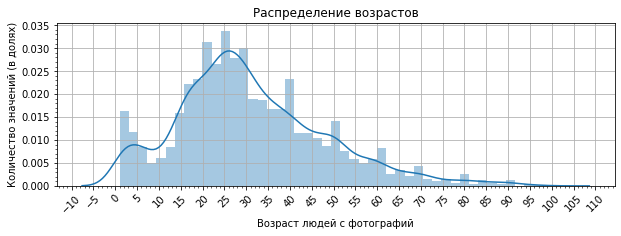

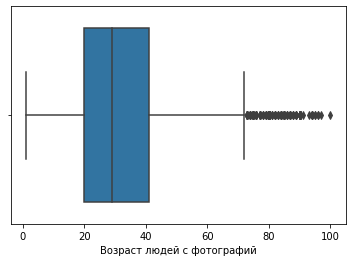

In [ ]:
print()
display('Какие возрасты представлены:', df['real_age'].sort_values().unique())

fig,ax = plt.subplots()
sns_plot = sns.distplot(df['real_age'])
fig = sns_plot.get_figure()
ax.grid()
ax.set_title('Распределение возрастов')
ax.set_xlabel('Возраст людей с фотографий')
ax.set_ylabel('Количество значений (в долях)')
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.minorticks_on()
plt.xticks(rotation = 45)
fig.set_size_inches(10, 3)
plt.show()

display(ax = sns.boxplot(data = df,
                         x = 'real_age',
                         orient = 'h'))
plt.xlabel('Возраст людей с фотографий')
plt.show()

Посмотрим на сами фотографии.

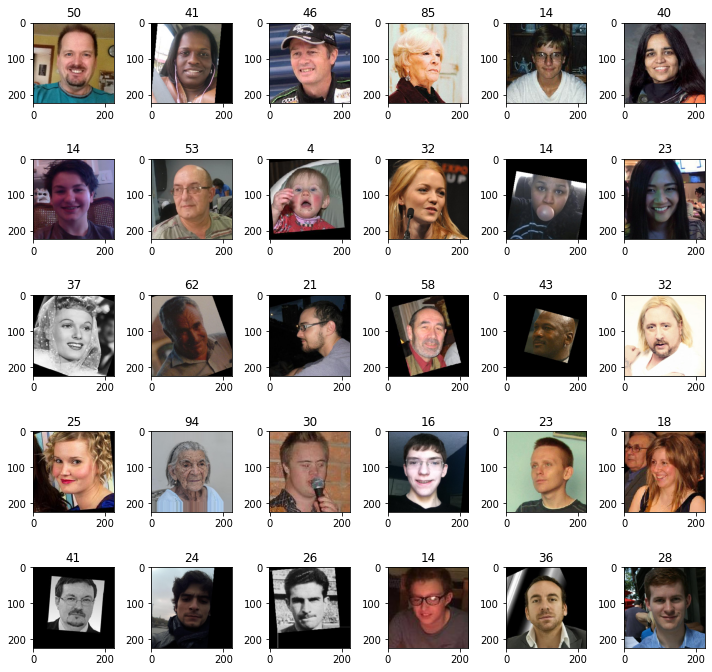

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(30):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.tight_layout()

## Вывод

    - Предоставлено 7591 изображения. Все с указанием возраста.
    - Возраст указан от 1 года до 100 лет без пропусков.
    - Максимально представлен возраст от 20 до 30 лет. Возраст после 70 почти не представлен.
    - Есть фото с лицами частично закрытыми очками, жвачкой, посторонними предметами. Есть разрисованные лица.
    - Есть фотографии без лиц (несколько пикселей обозначающих лицо не считается). А есть и по 2 лица.
    - Общая масса фото цветная, но имеются и черно-белые.
    - Все фото откалиброваны по размеру. Есть следы доворота фото до вертикального расположения лиц.
    - Количество фотографий на юбилейных годах портят график. Кто-то проставлял возраст вручную?

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split = 0.25,
                                       rescale = 1./255,
                                       horizontal_flip=True
                                       )
    train_data = train_datagen.flow_from_dataframe(dataframe = labels,
                                                   directory = path + 'final_files/',
                                                   x_col = 'file_name',
                                                   y_col = 'real_age',
                                                   subset = 'training',
                                                   target_size = (224, 224),
                                                   batch_size = 32,
                                                   class_mode = 'raw',
                                                   seed = 12345)
    return train_data
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split = 0.25,
                                      rescale = 1/255.)
    test_data = test_datagen.flow_from_dataframe(dataframe = labels,
                                                 directory = path + 'final_files/',
                                                 x_col = 'file_name',
                                                 y_col = 'real_age',
                                                 subset = 'validation',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'raw',
                                                 seed = 12345)
    return test_data
def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape = input_shape,
                        weights = 'imagenet',
                        include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()
             )
    model.add(Dense(1,
                    activation = 'relu')
             )
    model.compile(optimizer = optimizer,
                  loss = 'mean_absolute_error',
                  metrics = ['mae'])
    return model
def train_model(model,
                train_data,
                test_data,
                batch_size = None,
                epochs = 10, 
                steps_per_epoch = None,
                validation_steps = None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data = test_data,
              steps_per_epoch = steps_per_epoch, 
              validation_steps = validation_steps,
              verbose = 1,
              epochs = epochs,
              batch_size = batch_size)
    return model

```

Результат обработки кода выполненного в отдельном GPU-тренажёре:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 [ ==============] - 58s 323ms/step - loss: 11.6682 - mae: 11.6687 - val_loss: 23.5426 - val_mae: 23.5485
Epoch 2/10
178/178 [ ==============] - 34s 194ms/step - loss: 6.9759 - mae: 6.9760 - val_loss: 24.2186 - val_mae: 24.2254
Epoch 3/10
178/178 [ ==============] - 37s 205ms/step - loss: 5.6853 - mae: 5.6860 - val_loss: 13.7862 - val_mae: 13.7460
Epoch 4/10
178/178 [ ==============] - 35s 194ms/step - loss: 4.8996 - mae: 4.8998 - val_loss: 8.9858 - val_mae: 8.9636
Epoch 5/10
178/178 [ ==============] - 35s 194ms/step - loss: 4.2828 - mae: 4.2829 - val_loss: 6.8122 - val_mae: 6.8335
Epoch 6/10
178/178 [ ==============] - 35s 194ms/step - loss: 3.8127 - mae: 3.8126 - val_loss: 6.5197 - val_mae: 6.5514
Epoch 7/10
178/178 [ ==============] - 34s 193ms/step - loss: 3.4010 - mae: 3.4010 - val_loss: 6.3246 - val_mae: 6.3489
Epoch 8/10
178/178 [ ==============] - 34s 193ms/step - loss: 3.1469 - mae: 3.1470 - val_loss: 7.1473 - val_mae: 7.1392
Epoch 9/10
178/178 [ ==============] - 34s 194ms/step - loss: 2.9051 - mae: 2.9052 - val_loss: 6.1128 - val_mae: 6.1324
Epoch 10/10
178/178 [ ==============] - 34s 193ms/step - loss: 2.7484 - mae: 2.7480 - val_loss: 6.2568 - val_mae: 6.2833
WARNING:tensorflow:sample_weight modes were coerced from

60/60 - 9s - loss: 6.2568 - mae: 6.2833
Test MAE: 6.2833

```

## Вывод

Модель сверточной нейронной сети построена на ResNet50.

При параметре learning rate оптимизатора Adam равным 0.001 модель обучается слишком долго.

При lr=0.0001 на 10-й эпохе получилось уменьшить MAE до 6.3.

При lr=0.00001 за 10 эпох получилось уменьшить MAE только до 6.9.

## Анализ обученной модели

Цель проекта (построить модель, которая по фотографии определит приблизительный возраст человека) достигнута.

Обученная модель позволяет с точностью до 7 лет предсказывать возраст покупателей. 

Полученное значения МАЕв 6.28 - хороший показатель, если категоризировать пользователей с шагом от 10 лет и более. Что подходит для анализа покупок и предложения дополнительных товаров.

А вот для продажи алкоголя точность автоматически определенного возраста маловата, так как возрасты от 11 до 25 лет потребует дополнительных проверок.

Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество изображений с довольно высокой точностью.